In [1]:
import pandas
import numpy
import datetime
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy


In [2]:
# READ cpcp data from the csv file
cpcpDF = pandas.read_csv("../data/CPCP-2015.csv",\
                        parse_dates=['date'])
# READ DST data
cpcpDF.head()

,date,cpcp
0,2015-10-09 00:02:00,35
1,2015-10-09 00:04:00,33
2,2015-10-09 00:08:00,30
3,2015-10-09 00:12:00,31
4,2015-10-09 00:16:00,35


In [3]:
# READ dst data from the csv file
dstDF = pandas.read_csv("../data/dst-2015.csv", parse_dates=['date'])
# READ DST data
dstDF.head()

,date,dst
0,2015-01-01 00:00:00,-14.0
1,2015-01-01 01:00:00,-13.0
2,2015-01-01 02:00:00,-15.0
3,2015-01-01 03:00:00,-13.0
4,2015-01-01 04:00:00,-12.0


In [4]:
# Merge both dst and cpcp
# we'll merge the data on hour and day
dstDF["hour"] = [ x.hour for x in dstDF["date"] ]
dstDF["doy"] = [ x.dayofyear for x in dstDF["date"] ]
cpcpDF["hour"] = [ x.hour for x in cpcpDF["date"] ]
cpcpDF["doy"] = [ x.dayofyear for x in cpcpDF["date"] ]

In [5]:
# Actual merging of dst and cpcp
cpcpDF = pandas.merge( cpcpDF, dstDF,\
                          on = [ "hour", "doy" ] )

In [6]:
# Get mean and std variations in cpcp with dst
statDF = cpcpDF[ ["dst", "cpcp"] ].groupby( ["dst"] ).mean().reset_index()
statDF.columns = ["dst", "cpcp_mean"]
stdDF = cpcpDF[ ["dst", "cpcp"] ].groupby( ["dst"] ).std().reset_index()
stdDF.columns = ["dst", "cpcp_std"]
statDF = pandas.merge( statDF, stdDF, on="dst" )
statDF.head()

,dst,cpcp_mean,cpcp_std
0,-223.0,75.600000,6.173677
1,-214.0,76.600000,4.563833
2,-204.0,70.333333,5.690426
3,-190.0,65.733333,9.953224
4,-187.0,75.733333,6.192930


In [7]:
# setup plotting style
plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")

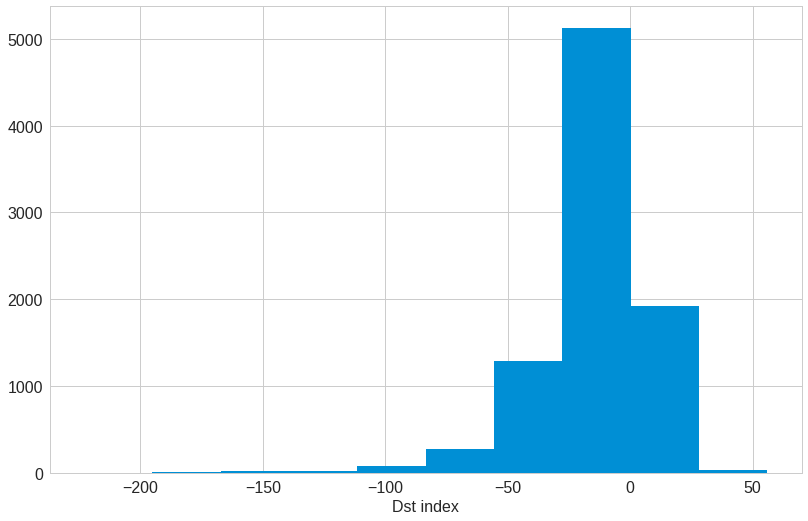

In [8]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

dstDF["dst"].hist(ax=ax)

ax.set_xlabel("Dst index", fontsize=16)
plt.tick_params(labelsize=16)

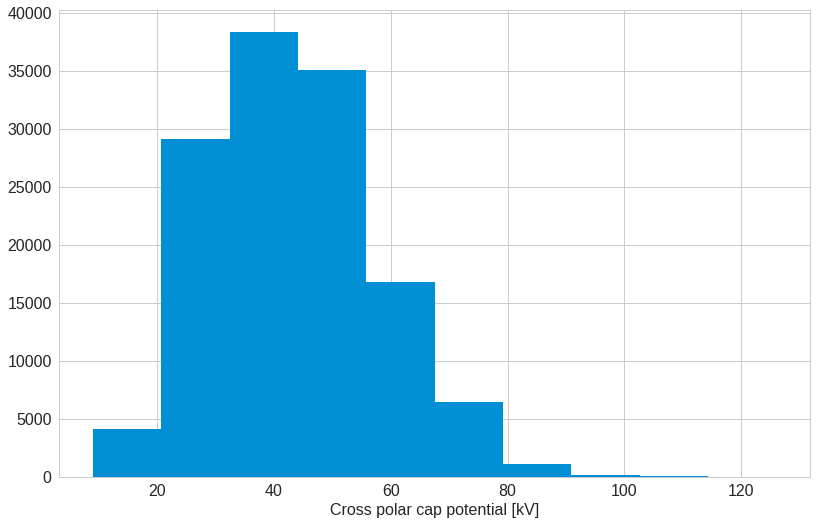

In [9]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

cpcpDF["cpcp"].hist(ax=ax)

ax.set_xlabel("Cross polar cap potential [kV]", fontsize=16)
plt.tick_params(labelsize=16)

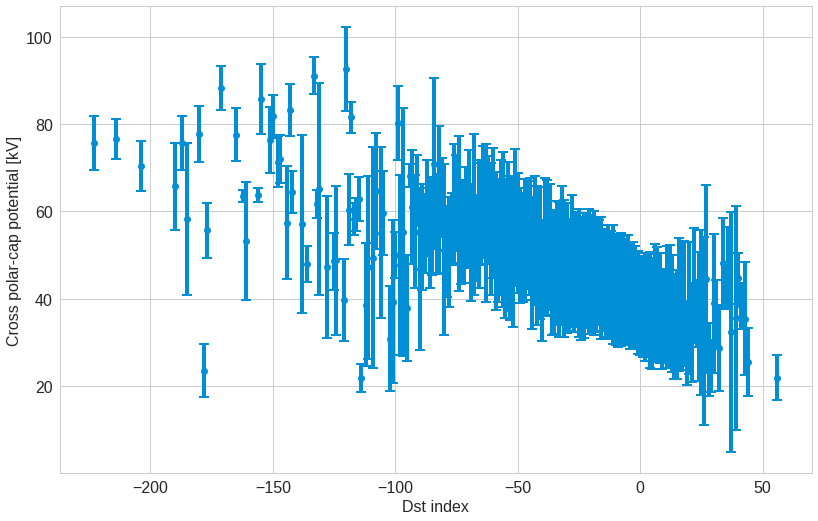

In [10]:

f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.errorbar(statDF['dst'],\
             statDF['cpcp_mean'],\
             yerr=statDF['cpcp_std'], fmt='o', \
             label='', capthick=2., capsize=5.)

ax.set_xlabel("Dst index", fontsize=16)
ax.set_ylabel("Cross polar-cap potential [kV]", fontsize=16)
plt.tick_params(labelsize=16)

In [11]:
# Linear regression function
def linear_func((dst), _a, _b):
    # func
    pred = _a + _b*(dst)
    return pred.ravel()

popt, pcov = curve_fit(linear_func, (statDF['dst'].T),\
                         statDF['cpcp_mean'], p0=( 1, 1 ))   

print "coefficients of fit"
print popt[0],"+/-", pcov[0,0]**0.5
print popt[1],"+/-", pcov[1,1]**0.5
# get the pred cpcp
statDF["cpcp_pred"] = popt[0] + popt[1]*(statDF['dst'])

coefficients of fit
41.77743331873928 +/- 0.899839016426529
-0.1579119373107862 +/- 0.010653165576580364


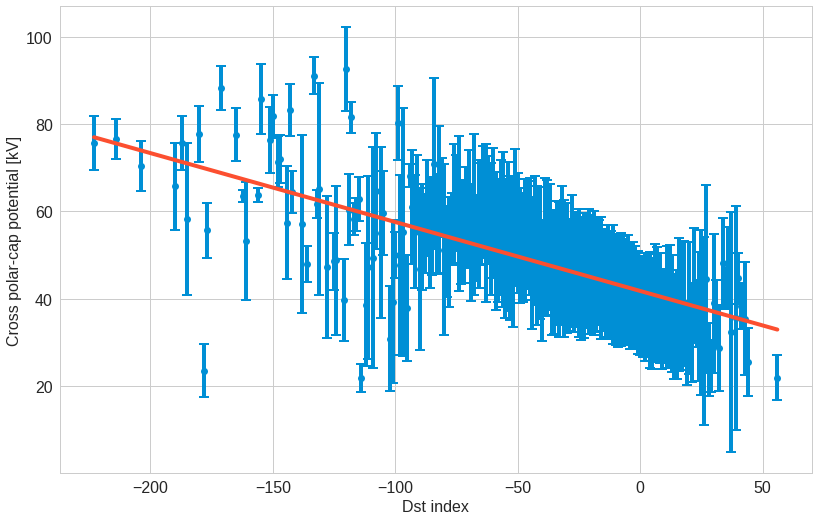

In [12]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

ax.errorbar(statDF['dst'],\
             statDF['cpcp_mean'],\
             yerr=statDF['cpcp_std'], fmt='o', \
             label='', capthick=2., capsize=5.)

ax.plot(statDF['dst'],
            statDF['cpcp_pred'], zorder=10 )

ax.set_xlabel("Dst index", fontsize=16)
ax.set_ylabel("Cross polar-cap potential [kV]", fontsize=16)
plt.tick_params(labelsize=16)